# 项目：调查病人就诊数据集

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> 本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

此次数据分析将研究：

1、Scheduled Day到Appointment Day这段间隔时间的长短对病人能否准时出席有无影响？

2、病人年龄太大了是否会对按时出席产生不便？

3、病人拥有某种障碍是否会对按时出席产生不便？

4、病人及时收到了短信提醒是否意味着按时出席的几率会增加？

In [1]:
#   导入语句
import pandas as pd
import matplotlib.pyplot as plt
# ‘咒语’
% matplotlib inline

<a id='wrangling'></a>
## 数据整理



### 常规属性

In [2]:
# 加载数据并打印几行。进行几项操作，检查数据
#   类型，以及是否有缺失数据或错误数据。
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


> PatientId和AppointmentID对于数据探索无贡献，予以删除

> ScheduledDay和AppointmentDay只需精确到日即可


In [3]:
df.shape

(110527, 14)

In [4]:
sum(df.duplicated())

0

> 使用duplicated( )后可以看到没有重复的行

In [5]:
# 检查错误数据
df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [6]:
print(sorted(set(df['Age'])))

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


> 发现年龄为-1的错误数据

In [7]:
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [8]:
df['SMS_received'].value_counts()

0    75045
1    35482
Name: SMS_received, dtype: int64

In [9]:
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


> 使用info( )后可以看到此数据集没有发现缺失值

### 数据清理（修正列名称，清理错误数据，删除无关列，转换格式）

In [11]:
# 清楚年龄的错误数据
df = df.query('Age >= 0')

In [12]:
# 更改列名称防止报错
# Hypertension写错啦，改过来
df.rename(columns = {'No-show': 'No_show', 'Hipertension': 'Hypertension'}, inplace=True)

In [13]:
# 讨论数据结构和需要解决的任何问题之后，
#   在本段的第二部分进行这些清理步骤。
# 删除无关列
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [14]:
# 将ScheduledDay和AppointmentDay列转换为datetime格式，并且仅保留年月日
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format = '%Y/%m/%d')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format = '%Y/%m/%d')
df['ScheduledDay'] = df['ScheduledDay'].dt.date
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format = '%Y/%m/%d')

In [15]:
# 检查是否完成了更改
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 12 columns):
Gender            110526 non-null object
ScheduledDay      110526 non-null datetime64[ns]
AppointmentDay    110526 non-null datetime64[ns]
Age               110526 non-null int64
Neighbourhood     110526 non-null object
Scholarship       110526 non-null int64
Hypertension      110526 non-null int64
Diabetes          110526 non-null int64
Alcoholism        110526 non-null int64
Handcap           110526 non-null int64
SMS_received      110526 non-null int64
No_show           110526 non-null object
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 11.0+ MB


In [16]:
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='eda'></a>
## 探索性数据分析


In [17]:
# 新增等待日期列
df['Wait_time'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
# 编写划分等待时间函数
def wait_time_range(wait_time):
    if wait_time >= 0 and wait_time < 30:
        return 'Within a month'
    elif wait_time >= 30 and wait_time < 60:
        return 'Over a month'
    elif wait_time >= 60 and wait_time < 90:
        return 'Over 2 months'
    else:
        return 'Over 3 months'
    
# 编写划分年龄段函数
def age_group(age):
    if age >= 0 and age < 25:
        return 'Young_aged'
    elif age >= 25 and age < 60:
        return 'Middle_aged'
    else:
        return 'Elderly'

In [18]:
# 先处理好新列，避免重复操作
df['Wait_time_range'] = df['Wait_time'].apply(lambda x: wait_time_range(x))
df['Age_group'] = df['Age'].apply(lambda x: age_group(x))

In [19]:
# 利用query将按时出席和没按时出席的病人放置在不同的dataframe中
# 设置Wait_time >= 0以防有ScheduledDay先于AppointmentDay的异常情况
showed_up = df.query("No_show == 'No' and Wait_time >= 0")
no_show = df.query("No_show == 'Yes' and Wait_time >= 0")

### 研究问题1: 预约等待时间短病人能否准时出席？

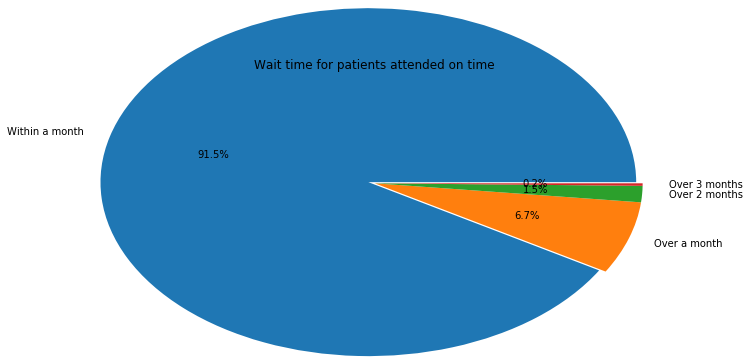

In [20]:
# 为按时出席的病人绘制饼图
temp_df1 = showed_up['Wait_time_range'].value_counts()
labels = list(temp_df1.index)
showed_pie = list(temp_df1)
explode = (0.05, 0, 0, 0)
plt.pie(showed_pie, explode=explode, labels=labels, autopct='%1.1f%%', radius=2);
plt.title('Wait time for patients attended on time');

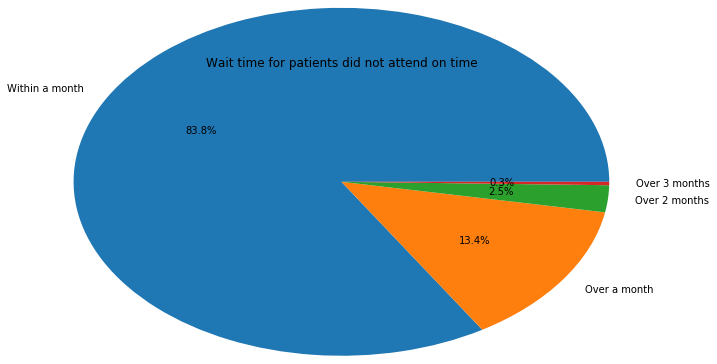

In [21]:
# 为未按时出席的病人绘制饼图
temp_df2 = no_show['Wait_time_range'].value_counts()
labels = list(temp_df2.index)
no_show_pie = list(temp_df2)
plt.pie(no_show_pie, labels=labels, autopct='%1.1f%%', radius=2);
plt.title('Wait time for patients did not attend on time');

> 比较两个饼图可知，即使Scheduled Day和Appointment Day相距不到一个月，在未按时出席预约的病人中也占绝不部分比例。可以初步说明，预约等待时间并不怎么影响病人是否缺席

### 研究问题 2：年龄，障碍，短信有无接收对病人按时出席是否有造成不便？

### 年龄的影响

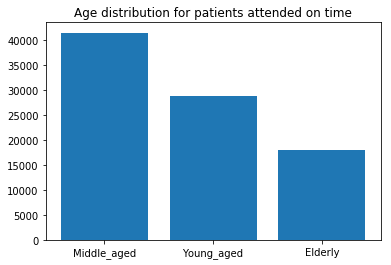

In [22]:
# 为按时出席的病人绘制饼图
temp_df3 = showed_up['Age_group'].value_counts()
labels = list(temp_df3.index)
showed_age = list(temp_df3)
plt.bar([1,2,3], showed_age, tick_label = labels);
plt.title('Age distribution for patients attended on time');

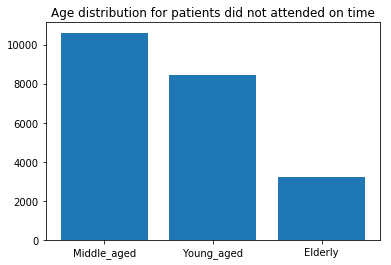

In [23]:
# 为未按时出席的病人绘制饼图
temp_df4 = no_show['Age_group'].value_counts()
labels = list(temp_df4.index)
no_show_age = list(temp_df4)
plt.bar([1,2,3], no_show_age, tick_label = labels);
plt.title('Age distribution for patients did not attended on time');

> 可以直观地看出， 两柱状图图形相似，老年人在其中所占比例相差不大，甚至在未出席的病人中老年人所占比例还有所下降。可以初步说明，年龄大对病人按时出席没有造成不便。

### 有障碍的影响

In [24]:
# 对按时出席病人进行统计
has_handicap = 0
total = 0
for b in showed_up['Handcap']:
    if b == 0:
        total += 1
    else:
        has_handicap += 1
        total += 1
showed_pct = (has_handicap/total) * 100
print('Proportion of handicap in patients attended on time: {}%'.format(showed_pct))

Proportion of handicap in patients attended on time: 2.0792000634870247%


In [25]:
# 对未按时出席病人进行统计
has_handicap = 0
total = 0
for b in no_show['Handcap']:
    if b == 0:
        total += 1
    else:
        has_handicap += 1
        total += 1
no_show_pct = (has_handicap/total) * 100
print('Proportion of handicap in patients did not attended on time: {}%'.format(no_show_pct))

Proportion of handicap in patients did not attended on time: 1.815004033342296%


> 通过比较看到，二者比例相差甚微，只相差0.2个百分点，因此很难说病人未按时出席是由于拥有障碍造成的

### 有无接收到短信的影响

In [26]:
# 对按时出席病人进行统计
sms_received = 0
total = 0
for c in showed_up['SMS_received']:
    if c == 0:
        total += 1
    else:
        sms_received += 1
        total += 1
showed_sms = (sms_received/total) * 100
print('Proportion of attended on time patients received sms: {}%'.format(showed_sms))

Proportion of attended on time patients received sms: 29.133742220005214%


In [27]:
# 对未按时出席病人进行统计
sms_received = 0
total = 0
for c in no_show['SMS_received']:
    if c == 0:
        total += 1
    else:
        sms_received += 1
        total += 1
no_show_sms = (sms_received/total) * 100
print('Proportion of did not attended on time patients received sms: {}%'.format(no_show_sms))

Proportion of did not attended on time patients received sms: 43.846912252397594%


> 通过计算得到，未按时出席的病人中接收到短信的比例甚至高于按时出席的病人，可以初步说明，是否接收到短信对病人是否缺席是没有影响的。

<a id='conclusions'></a>
## 结论

> 在本次数据分析中，集中对病人能否准时出席这一主要问题进行调查。利用了饼图，柱状图和计算的方式呈现数据。

> 数据探索的结果发现，预约的等待时间，病人本身的身体素质（年龄与是否有障碍）和是否接收到短信提醒对病人是否准时出席都没有太大的影响。具体影响因素仍然未知。

### 限制因素

> 样本的多样性：尽管样本数量比较大，但是在调查年龄时发现，老年人在整个数据集中占的比例比中年人和年轻人小得多，这一方面的因素可能对调查结果产生了影响

> Handcap列不明确：根据数据来源kaggle上对Handcap列的讨论，Handcap列上的数字代表病人有多少项身体障碍，但是没有对身体障碍的详细情况进行说明，一些身体障碍可能并不影响病人准时出席。此外，在数据分析过程中，由于Handcap列不明确，我只考虑了是否拥有身体障碍，即将拥有障碍的病人标记为1，没有身体障碍的病人标记为0进行分组，这对数据分析也会产生影响。


In [28]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255

> 参考：

> Kaggle上对Handcap列的讨论: https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699

> Pandas官方文档: http://pandas.pydata.org/pandas-docs/stable/

> Matplotlib官方文档: https://matplotlib.org/2.2.0/api/pyplot_summary.html